In [1]:
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torchaudio
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, SequentialSampler
from sklearn.model_selection import train_test_split
from adasp_data_management import music

import src.utils as utils
import src.models as models
import src.spectrograms as spec
import src.init as init

eps = 1e-6

/home/ids/edabier/miniconda3/envs/amt-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
    torch.set_default_device(dev)
else:
    dev = "cpu"

### Load the ground truth dataset

In [5]:
maps = music.Maps("/tsi/mir/maps")
metadata = maps.pdf_metadata

train_size = 0.8
train_data, test_data   = train_test_split(metadata, train_size=train_size, random_state=1)
train_data, valid_data  = train_test_split(train_data, train_size=train_size, random_state=1)

subset = 0.001
length = 3
sort = True
filt = True

train_set   = utils.MapsDataset(train_data, fixed_length=length, subset=subset, verbose=True, sort=sort, filter=filt)
test_set    = utils.MapsDataset(test_data, fixed_length=length, subset=subset, verbose=True, sort=sort, filter=filt)
valid_set   = utils.MapsDataset(valid_data, fixed_length=length, subset=subset, verbose=True, sort=sort, filter=filt)

batch_size      = 2
train_sampler   = utils.SequentialBatchSampler(train_set, batch_size=batch_size)
train_loader    = DataLoader(train_set, batch_sampler=train_sampler, collate_fn=utils.collate_fn)

test_sampler   = utils.SequentialBatchSampler(test_set, batch_size=batch_size)
test_loader     = DataLoader(test_set, batch_sampler=test_sampler, collate_fn=utils.collate_fn)

valid_sampler   = utils.SequentialBatchSampler(valid_set, batch_size=batch_size)
valid_loader    = DataLoader(valid_set, batch_sampler=valid_sampler, collate_fn=utils.collate_fn)

Maps: load metadata file /tsi/mir/maps/metadata.csv
Computing the length of files...


23it [00:01, 11.69it/s]


Computing the length of files...


7it [00:00, 24.25it/s]


Computing the length of files...


5it [00:00, 22.51it/s]


In [ ]:
maps = music.Maps("/tsi/mir/maps")
metadata = maps.pdf_metadata
dataset = utils.MapsDataset(metadata, fixed_length=False, subset=0.01, verbose=True, sort=True, mean_filter=True)

train_size = 0.8
batch_size = 2

sampler = utils.SequentialBatchSampler(dataset, batch_size)
data_loader = DataLoader(dataset, batch_sampler=sampler, collate_fn=utils.collate_fn)

# Create DataLoaders for training and validationw
train_loader = []
valid_loader = []

for i, batch in enumerate(data_loader):
    if i % 5 == 0:  # Every 5th batch goes to validation
        valid_loader.append(batch)
    else:
        train_loader.append(batch)
print(f"Train dataset: {len(train_loader)}, valid dataset: {len(valid_loader)}")

Train dataset: 69, valid dataset: 18


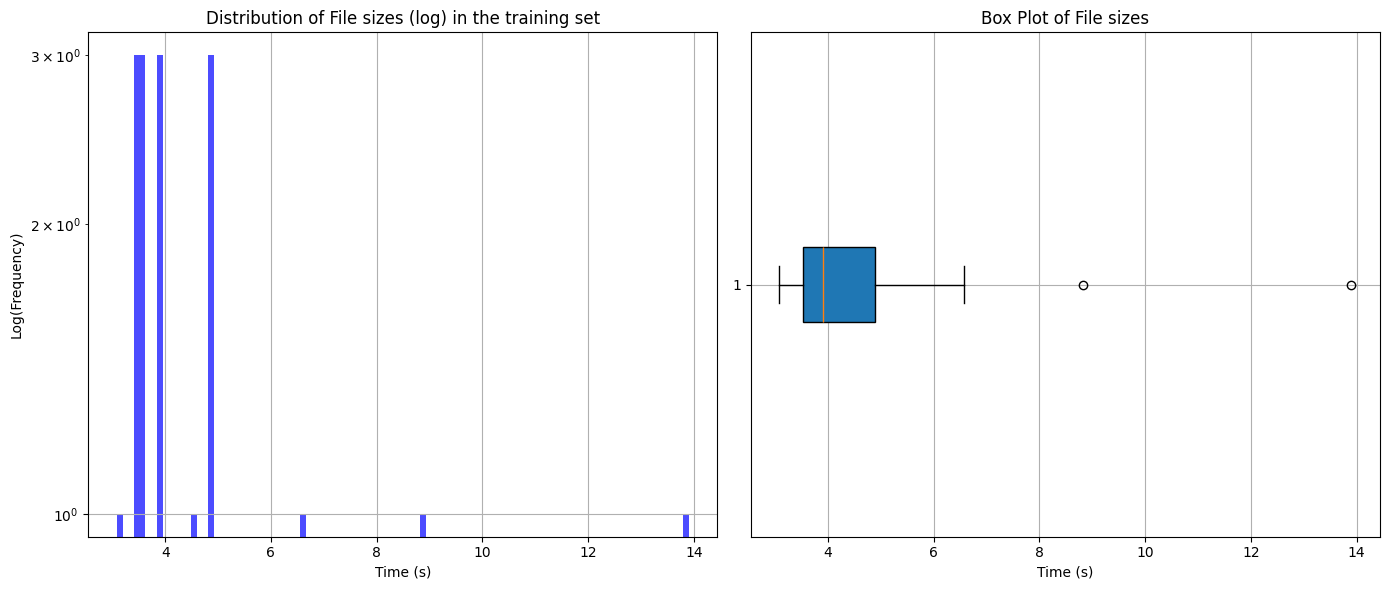

In [7]:
sizes = train_set.metadata.duration
mean_size = np.mean(sizes)
std_size = np.std(sizes)

# Histogram with logarithmic scale
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(sizes, bins=100, alpha=0.7, color='blue', log=True)
plt.title('Distribution of File sizes (log) in the training set')
plt.xlabel('Time (s)')
plt.ylabel('Log(Frequency)')
plt.grid(True)

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(sizes, vert=False, patch_artist=True)
plt.title('Box Plot of File sizes')
plt.xlabel('Time (s)')
plt.grid(True)

plt.tight_layout()
plt.show()

### Harmonicity score:

In [ ]:
W_path_synth = 'test-data/synth-single-notes'
W_path_piano = 'test-data/piano-single-notes'
W_synth, _, _, _ = init.init_W(W_path_synth, normalize=True)
W_piano, _, _, _ = init.init_W(W_path_piano, normalize=True)
W_synthetic, _, _, _ = init.init_W(normalize=False)

sigma = 0.01
W_noisy = W_synth + sigma*torch.rand(W_synth.shape)
noise = torch.rand(W_synthetic.shape)

In [ ]:
log_val = 1e-5

harmonicity_synth = torch.mean(utils.spectral_flatness(W_synth, log_val))
harmonicity_piano = torch.mean(utils.spectral_flatness(W_piano, log_val))
harmonicity_synthetic = torch.mean(utils.spectral_flatness(W_synthetic, log_val))
harmonicity_noisy = torch.mean(utils.spectral_flatness(W_noisy, log_val))
harmonicity_noise = torch.mean(utils.spectral_flatness(noise, log_val))
print(f"synth = {harmonicity_synth}, piano = {harmonicity_piano}, synthetic = {harmonicity_synthetic}, noisy = {harmonicity_noisy}, noise = {harmonicity_noise}")

### Create the model
`hidden`=`8`, `shared`=`True` => 1122 params

In [8]:
W_path = 'test-data/synth-single-notes'
ralmu = models.RALMU(l=88, beta=1, W_path=W_path, n_iter=10, n_init_steps=1, hidden=8, shared=True, return_layers=False, batch_size=batch_size, smaller_A=True)
utils.model_infos(ralmu, names=False)
ralmu

The model has 1122 parameters


RALMU(
  (layers): ModuleList(
    (0-9): 10 x RALMU_block(
      (Aw): Aw_cnn(
        (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.01)
        (softplus): Softplus(beta=1.0, threshold=20.0)
      )
      (Ah): Ah_cnn(
        (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.

### Train the model

In [9]:
optimizer   = torch.optim.AdamW(ralmu.parameters(), lr=1e-2)
criterion   = nn.MSELoss()
# device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ralmu = ralmu.to(dev)
epochs      = 5

train1 = False
n_epochs1 = 10
optimizer1 = torch.optim.AdamW(ralmu.parameters(), lr=1e-2)

# losses, W_warmup, H_warmup, H1 = utils.warmup_train(ralmu, n_epochs1, train_loader, optimizer1, device, debug=True)

losses, valid_losses, W_hat, H_hat = utils.train(ralmu, train_loader, optimizer, criterion, dev, epochs, valid_loader)

# spec.vis_cqt_spectrogram(ralmu.W0, np.arange(ralmu.W0.shape[1]), np.arange(ralmu.W0.shape[0]), 0, ralmu.W0.shape[1])
# spec.vis_cqt_spectrogram(W_warmup.detach(), np.arange(W_warmup.shape[1]), np.arange(W_warmup.shape[0]), 0, W_warmup.shape[1])
# spec.vis_cqt_spectrogram(W_hat.detach(), np.arange(W_hat.shape[1]), np.arange(W_hat.shape[0]), 0, W_hat.shape[1])

plt.plot(losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.ylabel("MSE")
plt.xlabel("epochs")
plt.legend()

RuntimeError: expected scalar type Float but found Half

In [ ]:
dataset_name = "piano-dataset"
W_path = 'test-data/synth-single-notes'
y, sr = torchaudio.load(f"{dataset_name}/audios/example-6.wav")
y = y.to(dev)

M, times, _ = spec.cqt_spec(y, sr, hop_length=128)
M = M.to(dev)

midi, onset, offset, _ = spec.midi_to_pianoroll(f"{dataset_name}/midis/example-6.mid", y, times,128,sr)
midi = midi.to(dev)
active_midi = [i for i in range(88) if (midi[i, :] > 0).any().item()]
H = init.MIDI_to_H(midi, active_midi, onset, offset)
H = H.to(dev)
W, _, _, _ = init.init_W(W_path)
W = W.to(dev)

In [ ]:
model_path = 'models/RALMU.pt'
weights = torch.load(model_path)
# weights.pop("H0")
batch_size = 2
ralmu = models.RALMU(l=88, beta=1, W_path=W_path, n_iter=5, n_init_steps=1, hidden=8, shared=True, return_layers=False, batch_size=batch_size, smaller_A=True)

# ralmu.load_state_dict(weights)
# ralmu.init_H(M)
ralmu.eval()
W_hat, H_hat, M_hat = ralmu.forward(M, device=dev)
M_hat = M_hat.detach()

In [12]:
print(utils.compute_metrics(H_hat, H, threshold=1))

(0.0008055853920515575, 0.11764705882352941, 0.001600213361781571, 0.0625)


/home/ids/edabier/miniconda3/envs/amt-env/lib/python3.9/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Text(0.5, 1.0, 'diff with MU')

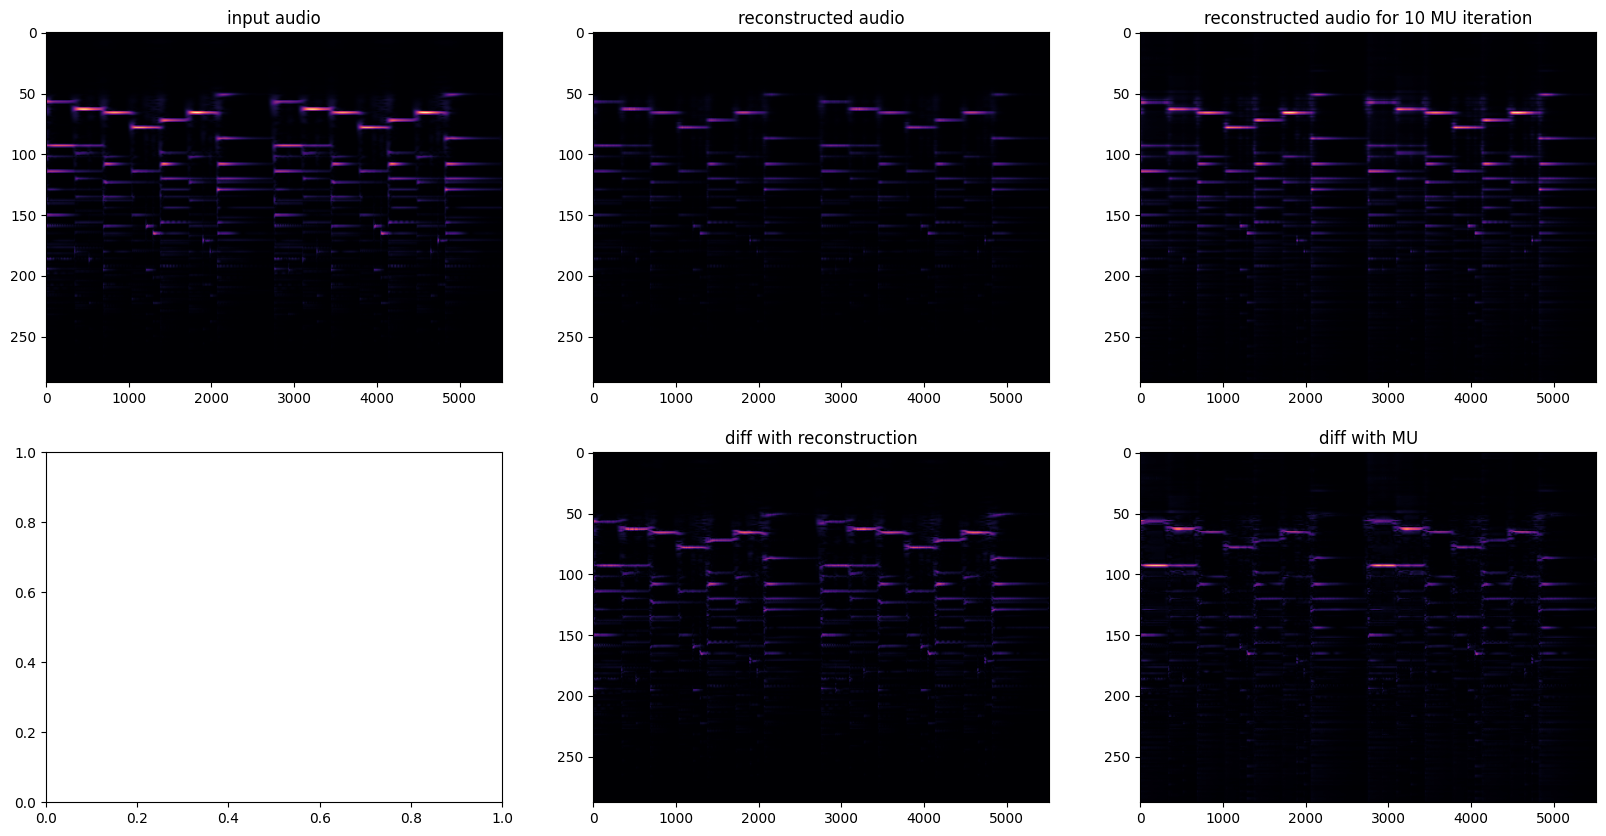

In [4]:
# M_n = np.apply_along_axis(lambda x: x / np.sum(np.abs(x)), axis=0, arr=M)
# M_hat_n = np.apply_along_axis(lambda x: x / np.sum(np.abs(x)), axis=0, arr=M_hat.detach())
n_steps = 10
H_mu = init.init_H(l=88, t=M.shape[1], W=torch.tensor(W), M=M, n_init_steps=n_steps)
M_mu = W @ H_mu

diff = np.abs(M.cpu() - M_hat.detach().cpu())
diff_r = np.abs(M.cpu() - M_mu.cpu())
fig, ax = plt.subplots(2, 3, figsize=(20,10))
ax[0, 0].imshow(M.cpu(), aspect="auto", cmap='magma')
ax[0, 0].set_title("input audio")

ax[0, 1].imshow(M_hat.cpu(),  aspect="auto", cmap='magma')
ax[0, 1].set_title("reconstructed audio")

ax[0, 2].imshow(M_mu.cpu(),  aspect="auto", cmap='magma')
ax[0, 2].set_title(f"reconstructed audio for {n_steps} MU iteration")

ax[1, 1].imshow(diff, aspect="auto", cmap='magma')
ax[1, 1].set_title("diff with reconstruction")

ax[1, 2].imshow(diff_r, aspect="auto", cmap='magma')
ax[1, 2].set_title("diff with MU")
# fig.colorbar(pos, ax=ax)

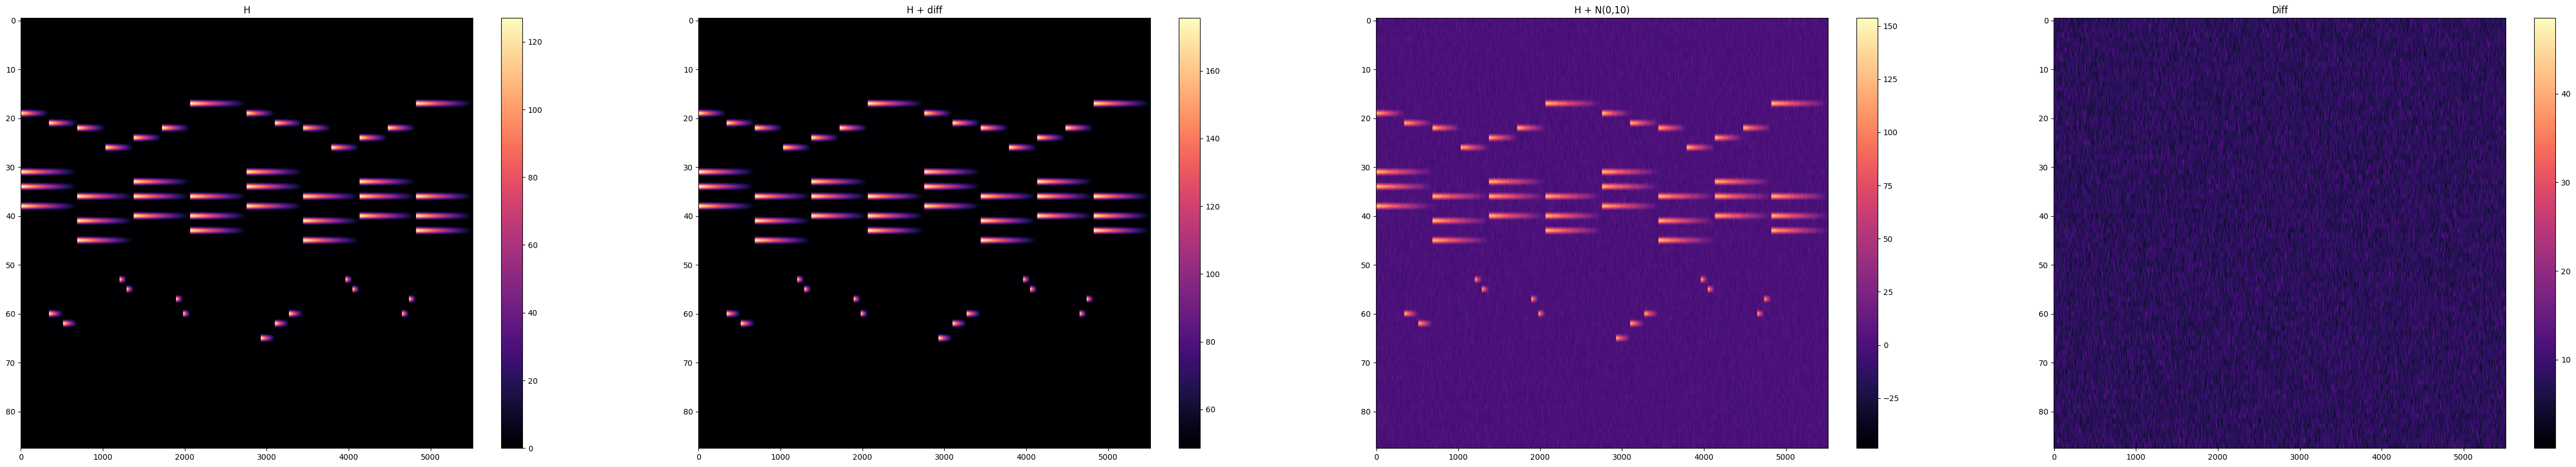

In [23]:
sigma = 10
H_m = H + sigma*torch.randn(H.shape)
diff = torch.abs(H_m - H)
H_2 = H + diff.max()*torch.ones_like(H)

fig, ax = plt.subplots(1, 4, figsize=(60,10))

im1 = ax[0].imshow(H.cpu(),  aspect="auto", cmap='magma')
ax[0].set_title("H")
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(H_2.cpu(),  aspect="auto", cmap='magma')
ax[1].set_title("H + diff")
fig.colorbar(im2, ax=ax[1])

im3 = ax[2].imshow(H_m.cpu(),  aspect="auto", cmap='magma')
ax[2].set_title(f"H + N(0,{sigma})")
fig.colorbar(im3, ax=ax[2])

im4 = ax[3].imshow(diff.cpu(),  aspect="auto", cmap='magma')
ax[3].set_title("Diff")
fig.colorbar(im4, ax=ax[3])

In [23]:
import mir_eval
def compute_metrics(prediction, ground_truth, time_tolerance=0.05, threshold=0):
    """
    Compute the precision, recall, F-measure and the accuracy of the transcription using mir_eval
    """
    if prediction == []:
        return 0, 0, 0, 0
    
    gt_notes = extract_note_events(ground_truth)
    pred_notes = extract_note_events(prediction, threshold=threshold)
    
    if len(gt_notes) == 0 or len(pred_notes) == 0:
        return 0, 0, 0, 0
    
    gt_times = gt_notes[:,0:2]
    gt_pitch = gt_notes[:,2]
    
    pred_times = pred_notes[:,0:2]
    pred_pitch = pred_notes[:,2]
    
    if np.any(gt_pitch < 21) or np.any(pred_pitch < 21):
        raise ValueError("Pitch values must be valid MIDI notes (21 <= X <= 108).")

    prec, rec, f_mes, _ = mir_eval.transcription.precision_recall_f1_overlap(
        gt_times, gt_pitch, pred_times, pred_pitch, 
        offset_ratio = None, onset_tolerance = time_tolerance, pitch_tolerance = 0.1)

    return prec, rec, f_mes, gt_notes, pred_notes

def extract_note_events(piano_roll, threshold=0):
    """
    Creates a note_event object from a piano_roll tensor
    The note_event is a list of notes (start, end, pitch)
    """
    # Pad the tensor to handle edge cases
    padded_tensor = torch.zeros(piano_roll.shape[0], piano_roll.shape[1] + 2, device=piano_roll.device)
    padded_tensor[:, 1:-1] = piano_roll

    note_events = []
    note_starts = ((padded_tensor[:, :-1] <= threshold) & (padded_tensor[:, 1:] > threshold)).nonzero(as_tuple=True)
    note_ends = ((padded_tensor[:, :-1] > threshold) & (padded_tensor[:, 1:] <= threshold)).nonzero(as_tuple=True)

    # Iterate over each pitch and pair starts with ends
    for pitch in range(padded_tensor.shape[0]):
        starts = note_starts[1][note_starts[0] == pitch]
        ends = note_ends[1][note_ends[0] == pitch]

        # Pair each start with an end
        for start, end in zip(starts, ends):
            note_events.append([start.item(), end.item(), pitch+21])

    return np.array(note_events, dtype=np.int32).reshape(-1, 3)

prec, rec, f, gt_notes, pred_notes = compute_metrics(H_m, H, threshold=diff.max())
print(prec, rec, f, len(gt_notes), len(pred_notes))

0.04717853839037928 1.0 0.0901060070671378 51 1081


In [28]:
prec, rec, f, acc, gt_notes, pred_notes = utils.compute_metrics(H_m, H, threshold=diff.max())
print(prec, rec, f, acc, len(pred_notes), len(gt_notes))

0.3893129770992366 1.0 0.5604395604395604 1.0 131 51


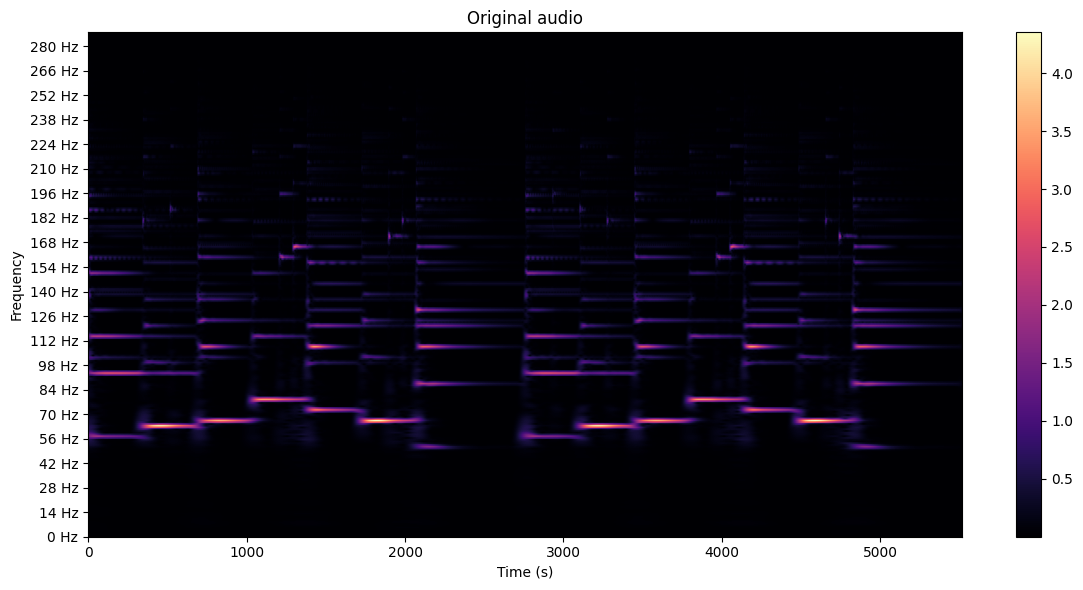

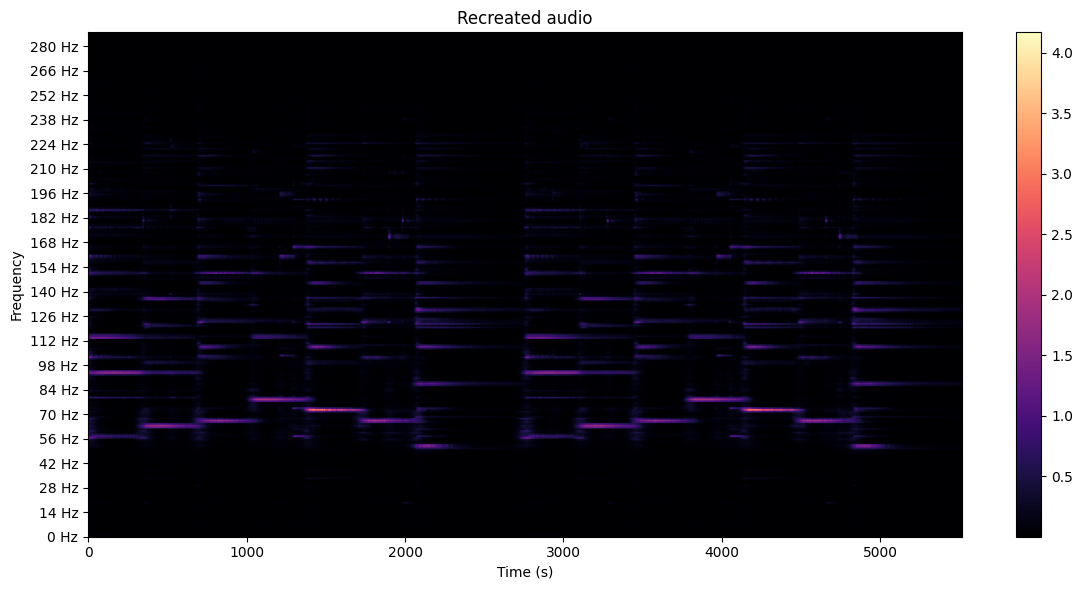

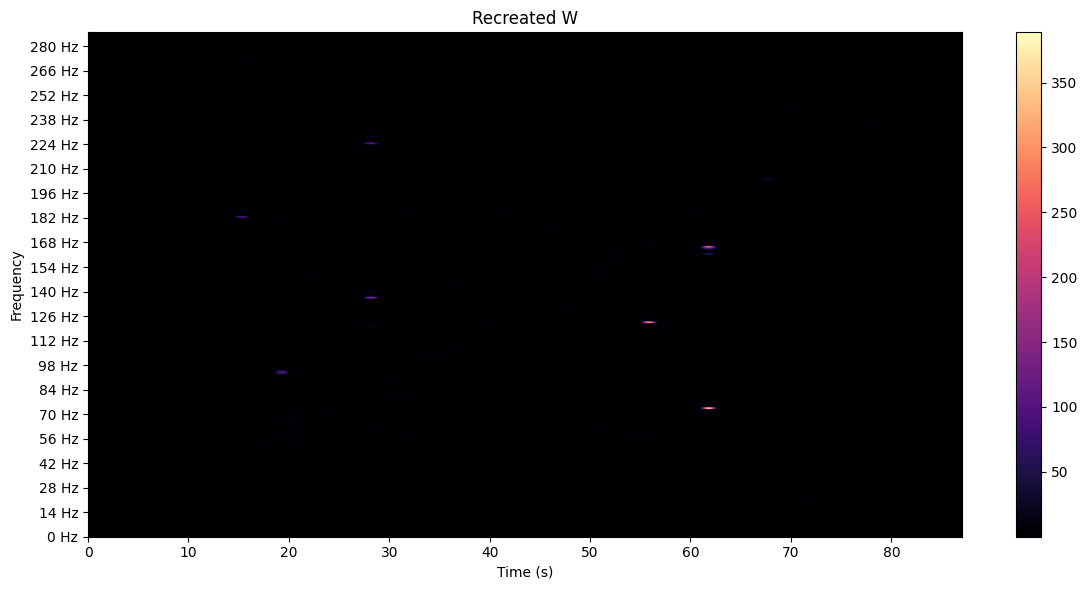

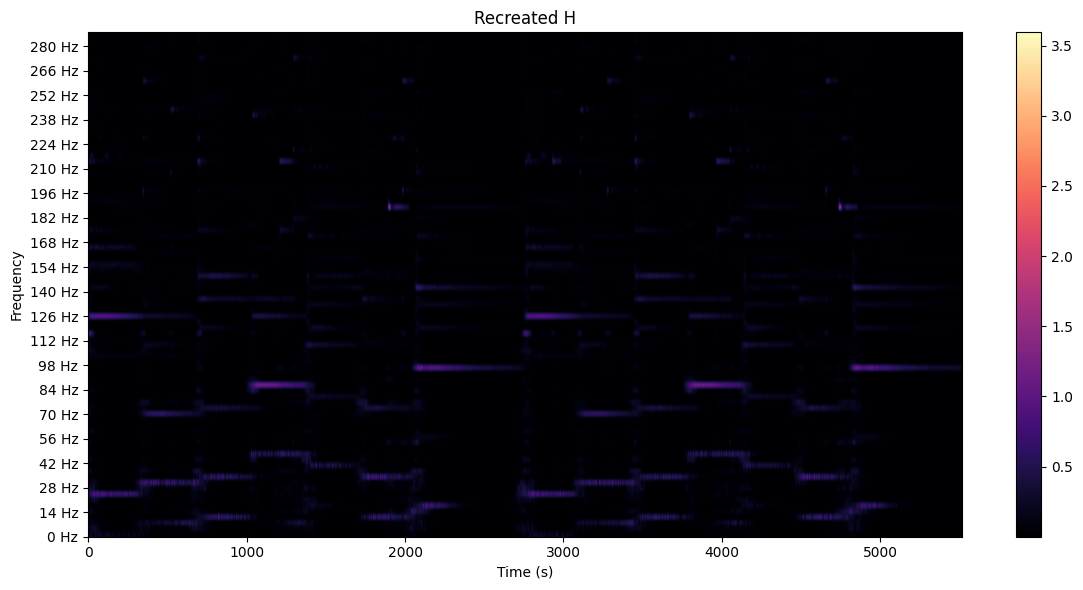

In [35]:
times = np.arange(M.shape[1])
freqs = np.arange(M.shape[0])

spec.vis_cqt_spectrogram(M, times, freqs, 0, times[-1], title="Original audio")
spec.vis_cqt_spectrogram(M_hat.detach(), times, freqs, 0, times[-1], title="Recreated audio")
spec.vis_cqt_spectrogram(W_hat.detach(), np.arange(88), freqs, 0, 88, title="Recreated W")
spec.vis_cqt_spectrogram(H_hat.detach(), times, freqs, 0, times[-1], title="Recreated H")